# Modeling

In [1]:
# read aaerFinStatmntsAnnual1971-2018.xlsx
import pandas as pd
import numpy as np
import xlrd
import csv
from openpyxl import load_workbook
import random
from itertools import product
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
import xgboost
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
import graphviz
import os     
import shap
import platform
#os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
import requests
import re

/Users/wenliang/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
# extract all raw data from aaerFinStatmntsAnnual1971-2018.xlsx
thisOS = 'Darwin'
if platform.system()==thisOS:
    folder = './'
    aaersourcefolder = './AAER_DataFiles/'
    usPubsourcefolder = './USPublice_DataFiles/'
    aaerfolder = './AAER_DataFiles/'
    usPubfolder = './USPublice_DataFiles/'
    visufolder = './Results/'
    valifolder = 'Validation'
else:
    folder = r'C:\Users\hi\Desktop\Data Manipulation'
    aaersourcefolder = folder+ r'\AAER'
    usPubsourcefolder = folder+ r'\usPublic'
    aaerfolder = folder+r'\Modeling\V3\AAER'
    usPubfoler = folder+r'\Modeling\V3\usPublic'
    visufolder = folder+r'\Modeling\V3\Visualization'

In [ ]:
# extract all raw data from aaerFinStatmntsAnnual1971-2018.xlsx
if platform.system()==thisOS:
    df = pd.read_excel(aaerfolder+r'aaerFinStatmntsAnnual1971-2018.xlsx')
else:
    df = pd.read_excel(aaersourcefolder+r'\aaerFinStatmntsAnnual1971-2018.xlsx')

In [ ]:
raw = df[['conm','fyear','cik','acctstd','indfmt','datafmt',
          'gp','revt','opiti','ebit','xt','cogs',
          'at','ppent','teq','lct','re','act',
          'invt','ch','lt','dt','dltt',
          'artfs','xopr','mkvalt',
         'sale','rect','ppegt','dp',
          'xsga','ni','oancf','txt',
          'tie','xopr']]
#change short column names to complete name
columnsNames = raw.columns.values
completeNames = ['Company Name','Fiscal Year','CIK','Accounting Standard','Industry Format','Data Format',
                 'Gross Profit','Sales Revenue','Operating Profit','EBIT','Total Expense','Cost of Goods Sold',
                 'Total Assets','Fixed Assets','Stockholders Equity','Current Liabilities','Retained Earnings','Current Assets',
                 'Inventories','Cash','Total Liabilities','Total Debt', 'Long-term Debt',
                 'Accounts Receivable', 'Operating Expenses','Market Value of Equity',
                'Sales/Turnover(Net)','Total Receivables','Property,Plant and Equipment','Depreciation and Amortization',
                'Selling, General and Administrative Expense','Net Income (Loss)','Operating Activities - Net Cash Flow','Taxes',
                 'Interest Expense','Operating Expense']
for i in range(0,36):
    columnsNames[i] = completeNames[i]

In [ ]:
raw.head()

### Remove Duplicated Rows

My solution is: 
<br>
1. Check the combination of 'acctstd','indfmt','datafmt';
<br>
2. for each pair of fyear and cik, check and compare the missing percentage (of needed variables) of each combination of 'acctstd','indfmt','datafmt';
<br>
3. Keep the row with lower combination

In [ ]:
comlists = df[['acctstd','indfmt','datafmt']].values.tolist()

In [ ]:
unique_list = [list(x) for x in set(tuple(x) for x in comlists)]
pairs = df[['fyear','cik']].values.tolist()
unique_pair = [list(x) for x in set(tuple(x) for x in pairs)]

In [ ]:
#calculate missing percentage for each row
raw['Missing Percent'] = (raw[raw.columns[6:]].isnull().sum(axis=1)/raw[raw.columns[6:]].shape[1]).values

In [ ]:
df_DuplicateRemove = pd.DataFrame()
for i in range(len(unique_pair)):
    year = unique_pair[i][0]
    cik = unique_pair[i][1]
    subraw = raw[(raw['Fiscal Year'] == year) & (raw['CIK'] == cik)]
    minMissingPercent = subraw['Missing Percent'].min()
    subraw = subraw[subraw['Missing Percent']==minMissingPercent]
    df_DuplicateRemove = df_DuplicateRemove.append(subraw)

In [ ]:
df_DuplicateRemove.head()

In [ ]:
df_DuplicateRemove.to_excel(aaerfolder+r'aaerComFinStmts_DuplicateRemove.xlsx')

### Filling in Missing Values

In [ ]:
df_DuplicateRemove =pd.read_excel(aaerfolder+r'aaerComFinStmts_DuplicateRemove.xlsx')

In [ ]:
df_DuplicateRemove.isnull().sum(axis=0)/len(df_DuplicateRemove)

In [ ]:
# Delete rows with all missing values
var=['Gross Profit','Sales Revenue','Operating Profit','EBIT','Total Expense','Cost of Goods Sold',
     'Total Assets','Fixed Assets','Stockholders Equity','Current Liabilities','Retained Earnings','Current Assets',
    'Inventories','Cash','Total Liabilities','Total Assets','Total Debt', 'Long-term Debt',
    'Accounts Receivable', 'Operating Expenses','Market Value of Equity',
    'Sales/Turnover(Net)','Total Receivables','Property,Plant and Equipment','Depreciation and Amortization',
    'Selling, General and Administrative Expense','Net Income (Loss)','Operating Activities - Net Cash Flow','Taxes',
     'Interest Expense','Operating Expense']
df_DuplicateRemove.dropna(axis=0,how='all',subset=var,inplace=True)
df_DuplicateRemove.set_index('Company Name')

In [ ]:
df_DuplicateRemove.isnull().sum(axis=0)/len(df_DuplicateRemove)

In [ ]:
# The interpolation of the most recent three years is still not ideal, therefore we apply KNN
# Note you may need to install fancyimpute:
#    1. https://www.lfd.uci.edu/~gohlke/pythonlibs/#lxml   here is the link you need to download wheel files, select the proper
#       version. The number after cp is the python version number, for example, 36 means 3.6.
#    2. Paste all downloaded wheel files to Script folder where your python is installed.
#    3. pip install "file path + file name"
#    4. pip install fancyimpute
"""
pip install D:\python3\Scripts\numpy-1.18.0+mkl-cp37-cp37m-win_amd64.whl
pip install D:\python3\Scripts\scipy-1.4.1-cp37-cp37m-win_amd64.whl
pip install D:\python3\Scripts\cvxopt-1.2.3-cp37-cp37m-win_amd64.whl
pip install D:\python3\Scripts\scs-2.1.1.post2-cp37-cp37m-win_amd64.whl
pip install D:\python3\Scripts\ecos-2.0.7.post1-cp37-cp37m-win_amd64.whl
pip install D:\python3\Scripts\CVXcanon-0.1.1-cp37-cp37m-win_amd64.whl
pip install D:\python3\Scripts\fastcache-1.1.0-cp37-cp37m-win_amd64.whl
pip install D:\python3\Scripts\cvxpy-1.0.25-cp37-cp37m-win_amd64.whl
pip install fancyimpute
"""
from fancyimpute import KNN
varneeded = ['CIK','Fiscal Year',
             'Gross Profit','Sales Revenue','Operating Profit','EBIT','Total Expense','Cost of Goods Sold',
             'Total Assets','Fixed Assets','Stockholders Equity','Current Liabilities','Retained Earnings','Current Assets',
             'Inventories','Cash','Total Liabilities','Total Assets','Total Debt', 'Long-term Debt',
             'Accounts Receivable', 'Operating Expenses','Market Value of Equity',
            'Sales/Turnover(Net)','Total Receivables','Property,Plant and Equipment','Depreciation and Amortization',
            'Selling, General and Administrative Expense','Net Income (Loss)','Operating Activities - Net Cash Flow','Taxes',
             'Interest Expense','Operating Expense']  
df_DuplicateRemove_varneeded = df_DuplicateRemove[varneeded]
#Use 5 nearest rows which have a feature to fill in each row's missing features
df_DuplicateRemove_completed= pd.DataFrame(KNN(k=5).fit_transform(df_DuplicateRemove_varneeded))  

In [ ]:
df_DuplicateRemove_completed.isnull().sum()

In [ ]:
# Since Knn tansfers column name to index, we have to rename the column
df_DuplicateRemove_completed.columns = ['CIK','Fiscal Year',
             'Gross Profit','Sales Revenue','Operating Profit','EBIT','Total Expense','Cost of Goods Sold',
             'Total Assets','Fixed Assets','Stockholders Equity','Current Liabilities','Retained Earnings','Current Assets',
             'Inventories','Cash','Total Liabilities','Total Assets','Total Debt', 'Long-term Debt',
             'Accounts Receivable', 'Operating Expenses','Market Value of Equity',
            'Sales/Turnover(Net)','Total Receivables','Property,Plant and Equipment','Depreciation and Amortization',
            'Selling, General and Administrative Expense','Net Income (Loss)','Operating Activities - Net Cash Flow','Taxes',
                                        'Interest Expense','Operating Expense']

In [ ]:
# Add back the company name column
coname = df_DuplicateRemove[['Company Name','CIK']].apply(tuple,axis=1).unique().tolist()
CompanyName = pd.DataFrame(coname, columns=['CONAME','CIK'])
print(len(df_DuplicateRemove))
df_DuplicateRemove_AfterInter = CompanyName.merge(df_DuplicateRemove_completed,how='inner',on='CIK')
print(len(df_DuplicateRemove_AfterInter))

In [ ]:
df_DuplicateRemove_AfterInter.to_excel(aaerfolder+r'aaerComFinStmts_DuplicateRemove_AfterInterpolation.xlsx')

### 2. Compute Ratios

In [ ]:
df_DuplicateRemove_AfterInter = pd.read_excel(aaerfolder+r'aaerComFinStmts_DuplicateRemove_AfterInterpolation.xlsx')

In [ ]:
#calculate financial ratios
# 1. Profitability ratios (return of sales)
df_DuplicateRemove_AfterInter['Gross Profit/Sales'] = df_DuplicateRemove_AfterInter['Gross Profit']/df_DuplicateRemove_AfterInter['Sales Revenue']
#df_DuplicateRemove_AfterInter['Operating Profit/Sales'] = df_DuplicateRemove_AfterInter['Operating Profit']/df_DuplicateRemove_AfterInter['Sales Revenue']
df_DuplicateRemove_AfterInter['EBIT/Sales'] = df_DuplicateRemove_AfterInter['EBIT']/df_DuplicateRemove_AfterInter['Sales Revenue']
df_DuplicateRemove_AfterInter['EBT'] = df_DuplicateRemove_AfterInter['Sales Revenue']-(df_DuplicateRemove_AfterInter['Total Expense']-df_DuplicateRemove_AfterInter['Taxes'])
df_DuplicateRemove_AfterInter['EBT/Sales'] = df_DuplicateRemove_AfterInter['EBT']/df_DuplicateRemove_AfterInter['Sales Revenue']
df_DuplicateRemove_AfterInter['Net Profit'] = df_DuplicateRemove_AfterInter['Gross Profit']-df_DuplicateRemove_AfterInter['Operating Expense']-df_DuplicateRemove_AfterInter['Interest Expense']-df_DuplicateRemove_AfterInter['Taxes']
df_DuplicateRemove_AfterInter['Net Profit/Sales'] = df_DuplicateRemove_AfterInter['Net Profit']/df_DuplicateRemove_AfterInter['Sales Revenue']
df_DuplicateRemove_AfterInter['Net Profit/Gross Profit'] = df_DuplicateRemove_AfterInter['Net Profit']/df_DuplicateRemove_AfterInter['Gross Profit']
# 2. Profitability ratios (return of investment)
df_DuplicateRemove_AfterInter['Gross Profit/Total Assets'] = df_DuplicateRemove_AfterInter['Gross Profit']/df_DuplicateRemove_AfterInter['Total Assets']
df_DuplicateRemove_AfterInter['EBT/Total Assets'] = df_DuplicateRemove_AfterInter['EBT']/df_DuplicateRemove_AfterInter['Total Assets']
df_DuplicateRemove_AfterInter['Net Profit/Total Assets'] = df_DuplicateRemove_AfterInter['Net Profit']/df_DuplicateRemove_AfterInter['Total Assets']
df_DuplicateRemove_AfterInter['EBT/Fixed Assets'] = df_DuplicateRemove_AfterInter['EBT']/df_DuplicateRemove_AfterInter['Fixed Assets']
df_DuplicateRemove_AfterInter['Net Profit/Fixed Assets'] = df_DuplicateRemove_AfterInter['Net Profit']/df_DuplicateRemove_AfterInter['Fixed Assets']
df_DuplicateRemove_AfterInter['EBT/Equity'] = df_DuplicateRemove_AfterInter['EBT']/df_DuplicateRemove_AfterInter['Stockholders Equity']
df_DuplicateRemove_AfterInter['Net Profit/Equity'] = df_DuplicateRemove_AfterInter['Net Profit']/df_DuplicateRemove_AfterInter['Stockholders Equity']
df_DuplicateRemove_AfterInter['EBT/Current Liabilities'] = df_DuplicateRemove_AfterInter['EBT']/df_DuplicateRemove_AfterInter['Current Liabilities']
df_DuplicateRemove_AfterInter['Retained Earnings/Net Profit'] = df_DuplicateRemove_AfterInter['Retained Earnings']/df_DuplicateRemove_AfterInter['Net Profit']
# 3. Liquidity ratios
df_DuplicateRemove_AfterInter['Current Assets/Current Liabilities'] = df_DuplicateRemove_AfterInter['Current Assets']/df_DuplicateRemove_AfterInter['Current Liabilities']
df_DuplicateRemove_AfterInter['(Current Assets - Inventories)/Current Liabilities'] = (df_DuplicateRemove_AfterInter['Current Assets']-df_DuplicateRemove_AfterInter['Inventories'])/df_DuplicateRemove_AfterInter['Current Liabilities']
df_DuplicateRemove_AfterInter['Cash/Total Liabilities'] = df_DuplicateRemove_AfterInter['Cash']/df_DuplicateRemove_AfterInter['Total Liabilities']
df_DuplicateRemove_AfterInter['Cash/Current Liabilities'] = df_DuplicateRemove_AfterInter['Cash']/df_DuplicateRemove_AfterInter['Current Liabilities']
df_DuplicateRemove_AfterInter['Working Capital'] = df_DuplicateRemove_AfterInter['Current Assets']-df_DuplicateRemove_AfterInter['Current Liabilities']
df_DuplicateRemove_AfterInter['Working Capital/Total Assets'] = df_DuplicateRemove_AfterInter['Working Capital']/df_DuplicateRemove_AfterInter['Total Assets']
# 4. Solvency ratios
df_DuplicateRemove_AfterInter['Total Liabilities/Total Assets'] = df_DuplicateRemove_AfterInter['Total Liabilities']/df_DuplicateRemove_AfterInter['Total Assets']
df_DuplicateRemove_AfterInter['Total Debt/Total Assets'] = df_DuplicateRemove_AfterInter['Total Debt']/df_DuplicateRemove_AfterInter['Total Assets']
df_DuplicateRemove_AfterInter['Long-term Debt/Total Assets'] = df_DuplicateRemove_AfterInter['Long-term Debt']/df_DuplicateRemove_AfterInter['Total Assets']
df_DuplicateRemove_AfterInter['Current Liabilities/Total Assets'] = df_DuplicateRemove_AfterInter['Current Liabilities']/df_DuplicateRemove_AfterInter['Total Assets']
df_DuplicateRemove_AfterInter['Equity/Total Assets'] = df_DuplicateRemove_AfterInter['Stockholders Equity']/df_DuplicateRemove_AfterInter['Total Assets']
df_DuplicateRemove_AfterInter['Total Liabilities/Equity'] = df_DuplicateRemove_AfterInter['Total Liabilities']/df_DuplicateRemove_AfterInter['Stockholders Equity']
df_DuplicateRemove_AfterInter['Total Debt/Equity'] = df_DuplicateRemove_AfterInter['Total Debt']/df_DuplicateRemove_AfterInter['Stockholders Equity']
df_DuplicateRemove_AfterInter['Long-term Debt/Equity'] = df_DuplicateRemove_AfterInter['Long-term Debt']/df_DuplicateRemove_AfterInter['Stockholders Equity']
df_DuplicateRemove_AfterInter['Fixed Assets/Long-term Liabilities'] = df_DuplicateRemove_AfterInter['Fixed Assets']/df_DuplicateRemove_AfterInter['Long-term Debt']
# 5. Activity ratios
df_DuplicateRemove_AfterInter['Inventories/Sales'] = df_DuplicateRemove_AfterInter['Inventories']/df_DuplicateRemove_AfterInter['Sales Revenue']
df_DuplicateRemove_AfterInter['Cost of Sales/Inventories'] = df_DuplicateRemove_AfterInter['Cost of Goods Sold']/df_DuplicateRemove_AfterInter['Inventories']
#df_DuplicateRemove_AfterInter['Accounts Receivable/Sales'] = df_DuplicateRemove_AfterInter['Accounts Receivable']/df_DuplicateRemove_AfterInter['Sales Revenue']
df_DuplicateRemove_AfterInter['Sales/Fixed Assets'] = df_DuplicateRemove_AfterInter['Sales Revenue']/df_DuplicateRemove_AfterInter['Fixed Assets']
df_DuplicateRemove_AfterInter['Sales/Total Assets'] = df_DuplicateRemove_AfterInter['Sales Revenue']/df_DuplicateRemove_AfterInter['Total Assets']
df_DuplicateRemove_AfterInter['Sales/Equity'] = df_DuplicateRemove_AfterInter['Sales Revenue']/df_DuplicateRemove_AfterInter['Stockholders Equity']
df_DuplicateRemove_AfterInter['Sales/Total Debt'] = df_DuplicateRemove_AfterInter['Sales Revenue']/df_DuplicateRemove_AfterInter['Total Debt']
df_DuplicateRemove_AfterInter['Cost of Sales/Sales'] = df_DuplicateRemove_AfterInter['Cost of Goods Sold']/df_DuplicateRemove_AfterInter['Sales Revenue']
df_DuplicateRemove_AfterInter['Operating Expenses/Sales'] = df_DuplicateRemove_AfterInter['Operating Expenses']/df_DuplicateRemove_AfterInter['Sales Revenue']
# 6. Structure ratios (Total assets structure ratios)
df_DuplicateRemove_AfterInter['Fixed Assets/Total Assets'] = df_DuplicateRemove_AfterInter['Fixed Assets']/df_DuplicateRemove_AfterInter['Total Assets']
df_DuplicateRemove_AfterInter['Current Assets/Total Assets'] = df_DuplicateRemove_AfterInter['Current Assets']/df_DuplicateRemove_AfterInter['Total Assets']
df_DuplicateRemove_AfterInter['(Inventories+Accounts Receivable)/Total Assets'] = (df_DuplicateRemove_AfterInter['Inventories']+df_DuplicateRemove_AfterInter['Accounts Receivable'])/df_DuplicateRemove_AfterInter['Total Assets']
df_DuplicateRemove_AfterInter['Inventories/Total Assets'] = df_DuplicateRemove_AfterInter['Inventories']/df_DuplicateRemove_AfterInter['Total Assets']
#df_DuplicateRemove_AfterInter['Accounts Receivable/Total Assets'] = df_DuplicateRemove_AfterInter['Accounts Receivable']/df_DuplicateRemove_AfterInter['Total Assets']
df_DuplicateRemove_AfterInter['Cash/Total Assets'] = df_DuplicateRemove_AfterInter['Cash']/df_DuplicateRemove_AfterInter['Total Assets']
# 7. structure ratios (Current assets structure ratios)
df_DuplicateRemove_AfterInter['Inventories/Current Assets'] = df_DuplicateRemove_AfterInter['Inventories']/df_DuplicateRemove_AfterInter['Current Assets']
df_DuplicateRemove_AfterInter['Cash/Current Assets'] = df_DuplicateRemove_AfterInter['Cash']/df_DuplicateRemove_AfterInter['Current Assets']
# 8. structure ratios (property structure ratios)
df_DuplicateRemove_AfterInter['Retained Earnings/Total Assets'] = df_DuplicateRemove_AfterInter['Retained Earnings']/df_DuplicateRemove_AfterInter['Total Assets']
df_DuplicateRemove_AfterInter['Retained Earnings/Equity'] = df_DuplicateRemove_AfterInter['Retained Earnings']/df_DuplicateRemove_AfterInter['Stockholders Equity']
df_DuplicateRemove_AfterInter['Current Liabilities/Total Liabilities'] = df_DuplicateRemove_AfterInter['Current Liabilities']/df_DuplicateRemove_AfterInter['Total Liabilities']
# 9. Altman’s (1968) financial distress measure (Z-score) 
df_DuplicateRemove_AfterInter['Altman’s (1968) financial distress measure (Z-score)'] = \
3.3*(df_DuplicateRemove_AfterInter['EBIT']/df_DuplicateRemove_AfterInter['Total Assets'])+ \
0.999*(df_DuplicateRemove_AfterInter['Sales Revenue']/df_DuplicateRemove_AfterInter['Total Assets']) + \
0.6*(df_DuplicateRemove_AfterInter['Market Value of Equity']/df_DuplicateRemove_AfterInter['Total Liabilities'])+ \
1.2*(df_DuplicateRemove_AfterInter['Working Capital']/df_DuplicateRemove_AfterInter['Total Assets'])+ \
1.4*(df_DuplicateRemove_AfterInter['Retained Earnings']/df_DuplicateRemove_AfterInter['Total Assets'])
                                                        

In [ ]:
# Calculate M-score

# Most of the M-score 8 ratios need variables of the previous year; therefore I have used pandas groupby() and shift() functions to create the previous year features.
df_DuplicateRemove_AfterInter['pre_Sales/Turnover(Net)'] = df_DuplicateRemove_AfterInter.sort_values(['Fiscal Year']).groupby('CIK')['Sales/Turnover(Net)'].shift()
df_DuplicateRemove_AfterInter['pre_Total Receivables'] = df_DuplicateRemove_AfterInter.sort_values(['Fiscal Year']).groupby('CIK')['Total Receivables'].shift()
df_DuplicateRemove_AfterInter['pre_Cost of Goods Sold'] = df_DuplicateRemove_AfterInter.sort_values(['Fiscal Year']).groupby('CIK')['Cost of Goods Sold'].shift()
df_DuplicateRemove_AfterInter['pre_Current Assets'] = df_DuplicateRemove_AfterInter.sort_values(['Fiscal Year']).groupby('CIK')['Current Assets'].shift()
df_DuplicateRemove_AfterInter['pre_Property,Plant and Equipment'] = df_DuplicateRemove_AfterInter.sort_values(['Fiscal Year']).groupby('CIK')['Property,Plant and Equipment'].shift()
df_DuplicateRemove_AfterInter['pre_Depreciation and Amortization'] = df_DuplicateRemove_AfterInter.sort_values(['Fiscal Year']).groupby('CIK')['Depreciation and Amortization'].shift()
df_DuplicateRemove_AfterInter['pre_Total Assets'] = df_DuplicateRemove_AfterInter.sort_values(['Fiscal Year']).groupby('CIK')['Total Assets'].shift()
df_DuplicateRemove_AfterInter['pre_Selling, General and Administrative Expense'] = df_DuplicateRemove_AfterInter.sort_values(['Fiscal Year']).groupby('CIK')['Selling, General and Administrative Expense'].shift()
df_DuplicateRemove_AfterInter['pre_Net Income (Loss)'] = df_DuplicateRemove_AfterInter.sort_values(['Fiscal Year']).groupby('CIK')['Net Income (Loss)'].shift()
df_DuplicateRemove_AfterInter['pre_Operating Activities - Net Cash Flow'] = df_DuplicateRemove_AfterInter.sort_values(['Fiscal Year']).groupby('CIK')['Operating Activities - Net Cash Flow'].shift()
df_DuplicateRemove_AfterInter['pre_Current Liabilities'] = df_DuplicateRemove_AfterInter.sort_values(['Fiscal Year']).groupby('CIK')['Current Liabilities'].shift()
df_DuplicateRemove_AfterInter['pre_Long-term Debt'] = df_DuplicateRemove_AfterInter.sort_values(['Fiscal Year']).groupby('CIK')['Long-term Debt'].shift()

# For later calculation
df_DuplicateRemove_AfterInter['Asset_qual'] = (df_DuplicateRemove_AfterInter['Total Assets']-df_DuplicateRemove_AfterInter['Current Assets']-df_DuplicateRemove_AfterInter['Property,Plant and Equipment'])/df_DuplicateRemove_AfterInter['Total Assets']
df_DuplicateRemove_AfterInter['pre_Asset_qual'] = (df_DuplicateRemove_AfterInter['pre_Total Assets']-df_DuplicateRemove_AfterInter['pre_Current Assets']-df_DuplicateRemove_AfterInter['pre_Property,Plant and Equipment'])/df_DuplicateRemove_AfterInter['pre_Total Assets']

# Eight ratios
df_DuplicateRemove_AfterInter['DSRI']=(df_DuplicateRemove_AfterInter['Total Receivables']/df_DuplicateRemove_AfterInter['Sales/Turnover(Net)'])/(df_DuplicateRemove_AfterInter['pre_Total Receivables']/df_DuplicateRemove_AfterInter['pre_Sales/Turnover(Net)'])
df_DuplicateRemove_AfterInter['GMI'] =  ((df_DuplicateRemove_AfterInter['pre_Sales/Turnover(Net)']-df_DuplicateRemove_AfterInter['pre_Cost of Goods Sold'])/df_DuplicateRemove_AfterInter['pre_Cost of Goods Sold']) / ((df_DuplicateRemove_AfterInter['Sales/Turnover(Net)']- df_DuplicateRemove_AfterInter['Cost of Goods Sold'])/ df_DuplicateRemove_AfterInter['Sales/Turnover(Net)'])
df_DuplicateRemove_AfterInter['AQI'] = df_DuplicateRemove_AfterInter['Asset_qual'] / df_DuplicateRemove_AfterInter['pre_Asset_qual']
df_DuplicateRemove_AfterInter['SGI'] = df_DuplicateRemove_AfterInter['Sales/Turnover(Net)'] / df_DuplicateRemove_AfterInter['pre_Sales/Turnover(Net)']
df_DuplicateRemove_AfterInter['DEPI'] = (df_DuplicateRemove_AfterInter['pre_Depreciation and Amortization'] / (df_DuplicateRemove_AfterInter['pre_Depreciation and Amortization'] + df_DuplicateRemove_AfterInter['pre_Property,Plant and Equipment'])) / (df_DuplicateRemove_AfterInter['Depreciation and Amortization'] / (df_DuplicateRemove_AfterInter['Depreciation and Amortization'] + df_DuplicateRemove_AfterInter['Property,Plant and Equipment']))
df_DuplicateRemove_AfterInter['SGAI'] = (df_DuplicateRemove_AfterInter['Selling, General and Administrative Expense'] / df_DuplicateRemove_AfterInter['Sales/Turnover(Net)']) / (df_DuplicateRemove_AfterInter['pre_Selling, General and Administrative Expense'] / df_DuplicateRemove_AfterInter['Sales/Turnover(Net)'])
df_DuplicateRemove_AfterInter['TA'] = (df_DuplicateRemove_AfterInter['Net Income (Loss)'] - df_DuplicateRemove_AfterInter['Operating Activities - Net Cash Flow']) / df_DuplicateRemove_AfterInter['Total Assets']
df_DuplicateRemove_AfterInter['LVGI'] = ((df_DuplicateRemove_AfterInter['Current Liabilities'] + df_DuplicateRemove_AfterInter['Long-term Debt']) / df_DuplicateRemove_AfterInter['Total Assets']) / ((df_DuplicateRemove_AfterInter['pre_Current Liabilities'] + df_DuplicateRemove_AfterInter['pre_Long-term Debt']) / df_DuplicateRemove_AfterInter['pre_Total Assets'])

df_DuplicateRemove_AfterInter['M-Score'] = -4.84 + \
                                           .920 * df_DuplicateRemove_AfterInter['DSRI'] + \
                                           .528 * df_DuplicateRemove_AfterInter['GMI'] + \
                                           .404 * df_DuplicateRemove_AfterInter['AQI'] + \
                                           .892 * df_DuplicateRemove_AfterInter['SGI'] + \
                                           .115 * df_DuplicateRemove_AfterInter['DEPI'] - \
                                           .172 * df_DuplicateRemove_AfterInter['SGAI'] + \
                                           4.679 * df_DuplicateRemove_AfterInter['TA'] - \
                                           .327 * df_DuplicateRemove_AfterInter['LVGI']

In [ ]:
#extrat financial ratios
financial_ratios = df_DuplicateRemove_AfterInter[['CONAME','CIK','Fiscal Year', 
                'Gross Profit/Sales','EBIT/Sales','EBT/Sales','Net Profit/Sales','Net Profit/Gross Profit',
                'Gross Profit/Total Assets','EBT/Total Assets','Net Profit/Total Assets','EBT/Fixed Assets','Net Profit/Fixed Assets',
                'EBT/Equity','Net Profit/Equity','EBT/Current Liabilities','Retained Earnings/Net Profit',
                'Current Assets/Current Liabilities','(Current Assets - Inventories)/Current Liabilities','Cash/Total Liabilities',
                'Cash/Current Liabilities','Working Capital/Total Assets',
                'Total Liabilities/Total Assets','Total Debt/Total Assets','Long-term Debt/Total Assets','Current Liabilities/Total Assets',
                'Equity/Total Assets','Total Liabilities/Equity','Total Debt/Equity','Long-term Debt/Equity','Fixed Assets/Long-term Liabilities',
                'Inventories/Sales','Cost of Sales/Inventories','Sales/Fixed Assets','Sales/Total Assets',
                'Sales/Equity','Sales/Total Debt','Cost of Sales/Sales','Operating Expenses/Sales',
                'Fixed Assets/Total Assets','Current Assets/Total Assets','(Inventories+Accounts Receivable)/Total Assets','Inventories/Total Assets',
                'Cash/Total Assets',
                'Inventories/Current Assets','Cash/Current Assets',
                'Retained Earnings/Total Assets','Retained Earnings/Equity','Current Liabilities/Total Liabilities',
                'Altman’s (1968) financial distress measure (Z-score)','M-Score']]
# removed ratios: 'Operating Profit/Sales','Accounts Receivable/Sales','Accounts Receivable/Total Assets'

In [ ]:
print(financial_ratios.isnull().sum(axis=0)/len(financial_ratios))
print(len(financial_ratios))

In [ ]:
# There are still few missing values. 
# There are some infinity values generated by division; Set inf as nan, and still adopt KNN to interpolate nan
financial_ratios=financial_ratios.replace([np.inf,-np.inf],np.nan)
rationeeded = ['CIK','Fiscal Year', 
               'Gross Profit/Sales','EBIT/Sales','EBT/Sales','Net Profit/Sales','Net Profit/Gross Profit',
                'Gross Profit/Total Assets','EBT/Total Assets','Net Profit/Total Assets','EBT/Fixed Assets','Net Profit/Fixed Assets',
                'EBT/Equity','Net Profit/Equity','EBT/Current Liabilities','Retained Earnings/Net Profit',
                'Current Assets/Current Liabilities','(Current Assets - Inventories)/Current Liabilities','Cash/Total Liabilities',
                'Cash/Current Liabilities','Working Capital/Total Assets',
                'Total Liabilities/Total Assets','Total Debt/Total Assets','Long-term Debt/Total Assets','Current Liabilities/Total Assets',
                'Equity/Total Assets','Total Liabilities/Equity','Total Debt/Equity','Long-term Debt/Equity','Fixed Assets/Long-term Liabilities',
                'Inventories/Sales','Cost of Sales/Inventories','Sales/Fixed Assets','Sales/Total Assets',
                'Sales/Equity','Sales/Total Debt','Cost of Sales/Sales','Operating Expenses/Sales',
                'Fixed Assets/Total Assets','Current Assets/Total Assets','(Inventories+Accounts Receivable)/Total Assets','Inventories/Total Assets',
                'Cash/Total Assets',
                'Inventories/Current Assets','Cash/Current Assets',
                'Retained Earnings/Total Assets','Retained Earnings/Equity','Current Liabilities/Total Liabilities',
                'Altman’s (1968) financial distress measure (Z-score)','M-Score']
financial_rationeeded = financial_ratios[rationeeded]
financial_rationeeded_AfterInter=pd.DataFrame(KNN(k=5).fit_transform(financial_rationeeded)) 
financial_rationeeded_AfterInter.columns = rationeeded
# Add back the company name column
print(len(financial_rationeeded))
financial_rationeeded_AfterInter_merge = CompanyName.merge(financial_rationeeded_AfterInter,how='inner',on='CIK')
print(len(financial_rationeeded_AfterInter_merge))
print(financial_rationeeded_AfterInter_merge.isnull().sum(axis=0)/len(financial_rationeeded_AfterInter_merge))

In [ ]:
financial_rationeeded_AfterInter_merge.to_excel(aaerfolder+r'aaerComFinStmts_DuplicateRemove_AfterInterpolation_ComputedRatios.xlsx')

## Labels

In [ ]:
#Read Current label cases
label_now = pd.read_excel(aaerfolder+r'aaerLabels2013-2019.xlsx',header=1,usecols=['CONAME','CIK','YEARA'])
print('For label_now, before removing rows with missing company name or yeara, the amount of rows is: ' +str(len(label_now)) )
# remoce rows with missing company name or cik
label_now.dropna(axis=0,subset=['CONAME'],inplace=True)
label_now.dropna(axis=0,subset=['YEARA'],inplace=True)
print('For label_now, before removing rows with missing company name or yeara, the amount of rows is: ' +str(len(label_now)) )

# Read past label cases
label_past = pd.read_excel(aaerfolder+r'DGLS_20160930_D.xlsx',sheet_name='ann',usecols=['CONAME','CIK','YEARA'])
print('For label_past, before removing rows with missing company name or yeara, the amount of rows is: ' +str(len(label_past)) )
# remove rows with missing fyear or cik
print(' \n The amount of NaNa in label_past is: \n'+ str(label_past.isnull().sum()))
label_past.dropna(axis=0,subset=['YEARA'],inplace=True)
print('For label_past, before removing rows with missing company name or yeara, the amount of rows is: ' +str(len(label_past)) )

# Read financial ratios dataframe
financial_ratios = pd.read_excel(aaerfolder+r'aaerComFinStmts_DuplicateRemove_AfterInterpolation_ComputedRatios.xlsx')
financial_ratios['CIK']=financial_ratios['CIK'].astype(float)
financial_ratios['Fiscal Year']=financial_ratios['Fiscal Year'].astype(float)
financial_ratios['Label'] = ''

# Concactate current and past label files
label_all = pd.concat([label_now,label_past],axis=0)
label_all['CONAME'] = label_all['CONAME'].str.strip()
label_all['CONAME'] = [re.sub(" +", " ",x)for x in label_all['CONAME']]
label_all['CIK'] = label_all['CIK'].astype(float)
label_all['YEARA'] = label_all['YEARA'].astype(float)
print('\n Before dropping duplicates, the amount of label_all is: '+str(len(label_all)))
#Drop duplicates
label_all['CIK_YEARA'] = label_all[['CIK','YEARA']].apply(tuple,axis=1)
label_all['CONAME_YEARA'] = label_all[['CONAME','YEARA']].apply(tuple,axis=1)
label_all_dropdup_1 = label_all.drop_duplicates(subset='CIK_YEARA',keep='first')
print('\n After dropping duplicates (CIK_YEARA), the amount of label_all_dropdup_1 is: '+str(len(label_all_dropdup_1)))
label_all_dropdup_2 = label_all_dropdup_1.drop_duplicates(subset='CONAME_YEARA',keep='first') 
print('\n After dropping duplicates(CONAME_YEARA), the amount of label_all_dropdup_2 is: '+str(len(label_all_dropdup_2)))
label_all_dropdup_2.to_excel(folder+r'label_allyears.xlsx')

# Create match list for tuples in label dataframes
label_all_cikYear = label_all_dropdup_2['CIK_YEARA'].unique().tolist()
label_all_conameYear = label_all_dropdup_2['CONAME_YEARA'].unique().tolist()
financial_ratios['CIK_FiscalYear']=financial_ratios[['CIK','Fiscal Year']].apply(tuple,axis=1)
financial_ratios['CONAME_FiscalYear']=financial_ratios[['CONAME','Fiscal Year']].apply(tuple,axis=1)

In [ ]:
# start to label
# Logic: firstly, CIK-YEARA is used to label; Secondly, if CIK is empty, apply CONAME-YEARA
for i in range(len(financial_ratios)): 
    cikYear = financial_ratios['CIK_FiscalYear'][i]
    conameYear = financial_ratios['CONAME_FiscalYear'][i]
    if cikYear in label_all_cikYear or conameYear in label_all_conameYear:
        financial_ratios['Label'][i] =1
    else:
        financial_ratios['Label'][i] =0

# Check the company name match cases
list1 = label_all['CONAME_YEARA'].unique().tolist()
print('The length of list1 is: '+str(len(list1)))
list2 = financial_ratios[financial_ratios['Label']==1]['CONAME_FiscalYear'].unique().tolist()
count = 0
for j in range(len(list1)):
    pair_label = list1[j]
    if pair_label in list2:
        pass
    else: 
        print(str(pair_label))

        

## Machine Learning Data Set

In [ ]:
ML_Dataset = financial_ratios[['CIK','Fiscal Year', 
                'Gross Profit/Sales','EBIT/Sales','EBT/Sales','Net Profit/Sales','Net Profit/Gross Profit',
                'Gross Profit/Total Assets','EBT/Total Assets','Net Profit/Total Assets','EBT/Fixed Assets','Net Profit/Fixed Assets',
                'EBT/Equity','Net Profit/Equity','EBT/Current Liabilities','Retained Earnings/Net Profit',
                'Current Assets/Current Liabilities','(Current Assets - Inventories)/Current Liabilities','Cash/Total Liabilities',
                'Cash/Current Liabilities','Working Capital/Total Assets',
                'Total Liabilities/Total Assets','Total Debt/Total Assets','Long-term Debt/Total Assets','Current Liabilities/Total Assets',
                'Equity/Total Assets','Total Liabilities/Equity','Total Debt/Equity','Long-term Debt/Equity','Fixed Assets/Long-term Liabilities',
                'Inventories/Sales','Cost of Sales/Inventories','Sales/Fixed Assets','Sales/Total Assets',
                'Sales/Equity','Sales/Total Debt','Cost of Sales/Sales','Operating Expenses/Sales',
                'Fixed Assets/Total Assets','Current Assets/Total Assets','(Inventories+Accounts Receivable)/Total Assets','Inventories/Total Assets',
                'Cash/Total Assets',
                'Inventories/Current Assets','Cash/Current Assets',
                'Retained Earnings/Total Assets','Retained Earnings/Equity','Current Liabilities/Total Liabilities',
                'Altman’s (1968) financial distress measure (Z-score)','M-Score','Label']]

In [ ]:
ML_Dataset.isnull().sum(axis=0)/len(ML_Dataset)

In [ ]:
ML_Dataset.to_excel(aaerfolder+r'aaerComFinStmts_DuplicateRemove_AfterInterpolation_ComputedRatios_MLDataset.xlsx')

## Concatenate AAER and US Public

In [ ]:
aaer = pd.read_excel(aaerfolder+r'aaerComFinStmts_DuplicateRemove_AfterInterpolation_ComputedRatios_MLDataset.xlsx')
uspublic = pd.read_excel(usPubfolder+r'usPublic_DuplicateRemove_AfterInterpolation_ComputedRatios_MLDataset.xlsx')

In [ ]:
big_df = pd.concat([aaer,uspublic])

In [ ]:
# Drop duplicates
big_df = big_df.drop_duplicates(subset=['CIK','Fiscal Year'],keep='first')

In [ ]:
big_df.to_excel(folder+r'FinalDf.xlsx')

## Diagnostic Model

In [3]:
raw = pd.read_excel(folder+r'FinalDf.xlsx')
raw = raw.round(2)
raw.head()

,Unnamed: 0,Unnamed: 0.1,CIK,Fiscal Year,Gross Profit/Sales,EBIT/Sales,EBT/Sales,Net Profit/Sales,Net Profit/Gross Profit,Gross Profit/Total Assets,...,Inventories/Total Assets,Cash/Total Assets,Inventories/Current Assets,Cash/Current Assets,Retained Earnings/Total Assets,Retained Earnings/Equity,Current Liabilities/Total Liabilities,Altman’s (1968) financial distress measure (Z-score),M-Score,Label
0,0,0,763950,1992,0.24,-0.17,1.00,-3.50,-14.47,0.48,...,0.41,0.19,0.42,0.20,-1.22,1.92,1.00,1.23,-2.10,0
1,1,1,763950,2000,0.36,-0.40,0.80,-5.10,-14.26,0.18,...,0.31,0.02,0.74,0.06,-0.93,3.16,0.59,-0.32,-3.73,0
2,2,2,763950,2004,1.00,-226.00,1.00,-846.19,-846.19,0.01,...,0.00,0.22,0.00,0.24,-12.62,86.04,1.00,-21.70,-17.62,0
3,3,3,763950,1987,0.61,0.18,1.08,-5.04,-8.29,0.86,...,0.32,0.04,0.47,0.07,0.09,-0.11,0.67,5.27,0.18,0
4,4,4,763950,1998,0.39,-0.22,1.00,-6.33,-16.42,0.37,...,0.55,0.02,0.74,0.03,-1.90,2.49,0.93,-0.23,-12.39,0


In [4]:
raw=raw.iloc[:,2:]
print(len(raw))

105924


In [5]:
#drop rows if the year does not have fraud causes/ does not have nonfraud cases

# count num_fraud and num_nonfraud
years = raw['Fiscal Year'].unique()
for year in years:
    raw_sorted_year = raw[raw['Fiscal Year']==year]
    num_fraud = len(raw_sorted_year[raw_sorted_year['Label']==1])
    if num_fraud<=-2:
        raw.drop(raw[raw['Fiscal Year']==year].index, inplace=True)
        
for year in years:
    raw_sorted_year = raw[raw['Fiscal Year']==year]
    num_nonfraud = len(raw_sorted_year[raw_sorted_year['Label']==0])
    if num_nonfraud<=-2:
        raw.drop(raw[raw['Fiscal Year']==year].index, inplace=True)
        
raw.to_excel(folder+r'FinalDf_DroppedNonFraudYears.xlsx')

print(len(raw))

105924


In [ ]:
"""
raw = pd.read_excel('FinalDf_DroppedNonFraudYears.xlsx')
# For each row, [fyear,cik] is created as a pair. If there is no [fyear+1,cik], drop that row
for i in range(len(raw)):
    fyear = raw.loc[i,'Fiscal Year']
    cik = raw.loc[i,'CIK']
    fyear_next = fyear+1
    fyear_next_list = raw.loc[raw['CIK']==cik,'Fiscal Year'].unique().tolist()
    if fyear_next not in fyear_next_list:
        raw.drop(raw[(raw['Fiscal Year']==fyear)&(raw['CIK']==cik)].index, inplace=True)
"""

In [6]:
raw = pd.read_excel(folder+r'FinalDf_DroppedNonFraudYears.xlsx')
# remove the unnamed column when reading FinalDf_DroppedNonFraudYears.xlsx
raw=raw.iloc[:,1:]
raw.head()

,CIK,Fiscal Year,Gross Profit/Sales,EBIT/Sales,EBT/Sales,Net Profit/Sales,Net Profit/Gross Profit,Gross Profit/Total Assets,EBT/Total Assets,Net Profit/Total Assets,...,Inventories/Total Assets,Cash/Total Assets,Inventories/Current Assets,Cash/Current Assets,Retained Earnings/Total Assets,Retained Earnings/Equity,Current Liabilities/Total Liabilities,Altman’s (1968) financial distress measure (Z-score),M-Score,Label
0,763950,1992,0.24,-0.17,1.00,-3.50,-14.47,0.48,1.99,-6.98,...,0.41,0.19,0.42,0.20,-1.22,1.92,1.00,1.23,-2.10,0
1,763950,2000,0.36,-0.40,0.80,-5.10,-14.26,0.18,0.40,-2.55,...,0.31,0.02,0.74,0.06,-0.93,3.16,0.59,-0.32,-3.73,0
2,763950,2004,1.00,-226.00,1.00,-846.19,-846.19,0.01,0.01,-10.07,...,0.00,0.22,0.00,0.24,-12.62,86.04,1.00,-21.70,-17.62,0
3,763950,1987,0.61,0.18,1.08,-5.04,-8.29,0.86,1.52,-7.11,...,0.32,0.04,0.47,0.07,0.09,-0.11,0.67,5.27,0.18,0
4,763950,1998,0.39,-0.22,1.00,-6.33,-16.42,0.37,0.96,-6.05,...,0.55,0.02,0.74,0.03,-1.90,2.49,0.93,-0.23,-12.39,0


In [ ]:
raw.dtypes

ML Method: Random Forest
ratioNegToPos: 2


***To predict year 2017, we use data from 1950-2016
In the training data set, num of positive samples: 1708; num of used negative samples: 3053 out of 98896
In the testing data set, num of positive samples: 3; num of negative samples: 4777
Accuracy: 0.8658995815899582
Sensitivity: 0.6666666666666666
Specificity: 0.8660247016956248
Balanced Accuracy: 0.7663456841811458


Number of trees: 35


***To predict year 2018, we use data from 1950-2017
In the training data set, num of positive samples: 1711; num of used negative samples: 3077 out of 103673
In the testing data set, num of positive samples: 0; num of negative samples: 540
Accuracy: 0.85
Sensitivity: 0.0
Specificity: 0.85
Balanced Accuracy: 0.425


Number of trees: 35


<Figure size 432x288 with 0 Axes>

<Figure size 576x684 with 0 Axes>

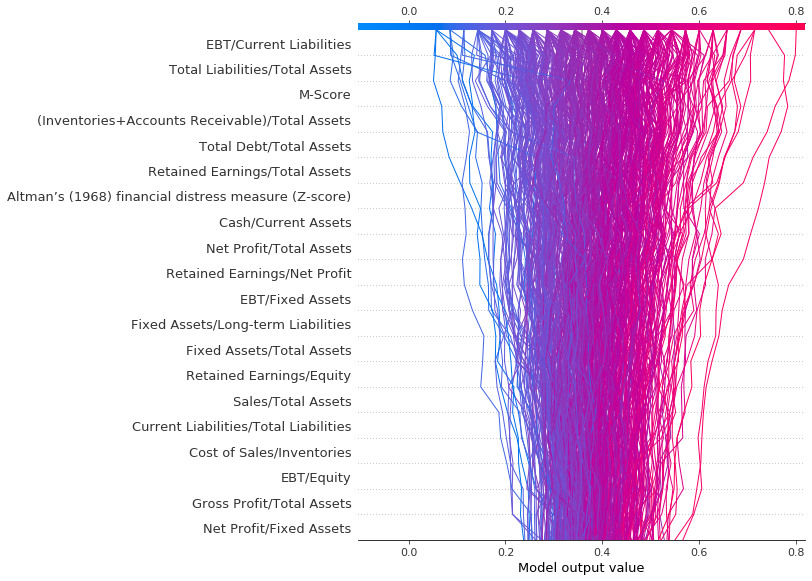

In [8]:
Method = 2 ## 0 for SVM, 1 for decision tree, 2 for random forest, 3 for adaboost, 4 for gbboost, 5 for xgboost
Method_name = "."
if Method==0:
    print("ML Method: SVM")
    Method_name = 'SVM/'
elif Method==1:
    print("ML Method: Decision Tree")
    Method_name = 'DecisionTree/'
elif Method==2:
    print("ML Method: Random Forest")
    Method_name = 'RandomForest/'
elif Method==3:
    print("ML Method: AdaBoost")
    Method_name = 'AdaBoost/'
elif Method==4:
    print("ML Method: GBBoost")
    Method_name = 'GBBoost/'
elif Method==5:
    print("ML Method: Xgboost")
    Method_name = 'XGBoost/'

neg2posratio = 2
firstPredYearFlag = True
print('ratioNegToPos: '+str(neg2posratio))

fnameAccuracy = os.path.join(visufolder, Method_name, valifolder, Method_name[0:len(Method_name)-1]+'-accuracy-results.csv')

with open(fnameAccuracy, "w") as accuCsvfile:
    accuCsvfile.write("year, nTrain, nPosTrain, nNegTrain, nTotPastNeg, nTest, nPosTest,nNegTest, accuracy, sensitivity, specificity, balanced accuracy\n")

    for year in range(2002,2019):
#     for year in range(2017,2019):

        # create training dataset
        endyear = year-1
        train = raw[raw['Fiscal Year']<=endyear]
        #create train_fraud
        train_fraud = train[train['Label']==1]
        #create train_nonfraud
        CIKs = train['CIK'].unique().tolist()
        train_nonfraud =pd.DataFrame()
        for cik in CIKs:
            # count num_fraud and num_nonfraud
            num_fraud = len(train[(train['Label']==1)&(train['CIK']==cik)])
            num_nonfraud = num_fraud*neg2posratio 
            num_nonfraud_actual = len(train[(train['Label']==0)&(train['CIK']==cik)])
            if num_nonfraud_actual<= num_nonfraud:
                # for each cik, if number of nonfraud cases is less then 2*fraud cases, then take all the nonfraud cases
                nonfraud = train[(train['Label']==0)&(train['CIK']==cik)]
                train_nonfraud=train_nonfraud.append(nonfraud)
            else:
                # for each cik, if number of nonfraud cases is greater then 2*fraud cases, randomly select the 2*fraudcases non-fraud cases
                nonfraud = train[(train['Label']==0)&(train['CIK']==cik)]
                nonfraud_selected = nonfraud.sample(n=num_nonfraud)
                train_nonfraud=train_nonfraud.append(nonfraud_selected)
        # merge train_fraud and train_nonfraud
        trainDf = pd.concat([train_fraud,train_nonfraud]).sort_values(['CIK','Fiscal Year'])
        years = train['Fiscal Year'].unique().tolist()
        startyear = min(years)
        # create test data
        testDf = raw[raw['Fiscal Year']==year]

        # Train model
        trainX = trainDf.iloc[:,2:50].values
        trainY = trainDf.iloc[:,50].values
        testX = testDf.iloc[:,2:50].values
        testY = testDf.iloc[:,50].values
        # Implement SVM or others

        # Method = 2 ## 0 for SVM, 1 for decision tree, 2 for random forest, 3 for adaboost, 4 for gbboost, 5 for xgboost
        if Method==0:
            classifier = SVC(kernel='rbf', random_state = 1)
            classifier.fit(trainX,trainY)
        elif Method==1:
            classifier = DecisionTreeClassifier(max_depth=30)
            regressor = DecisionTreeRegressor(max_depth=30)
            classifier.fit(trainX,trainY)
            regressor.fit(trainX,trainY)
        elif Method==2:
            params = {'n_estimators': 10, 'max_depth': 35, 'min_samples_split': 2 }
            regressor = RandomForestRegressor(max_depth=35, random_state=10, n_estimators=35)
            classifier = RandomForestClassifier(max_depth=35, random_state=10, n_estimators=35)
            regressor.fit(trainX,trainY)
            classifier.fit(trainX,trainY)
        elif Method==3:
            params = {'n_estimators': 10, 'max_depth': 35, 'min_samples_split': 2 }
            classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10), n_estimators=50)
            regressor = AdaBoostRegressor(DecisionTreeRegressor(max_depth=10), n_estimators=50)
            classifier.fit(trainX,trainY)
            regressor.fit(trainX,trainY)
        elif Method==4:
            params = {'n_estimators':100,'max_depth':35, 'min_samples_split':2,'learning_rate': 0.05}
            classifier = GradientBoostingClassifier(**params)    
            regressor = GradientBoostingRegressor(**params)    
            classifier.fit(trainX,trainY)
            regressor.fit(trainX,trainY)
        elif Method==5:
           # dtrain = xgboost.DMatrix(trainX, label=trainY)
            dtest = xgboost.DMatrix(testX)
            classifier = xgboost.XGBClassifier(max_depth=30, learning_rate=0.10, n_estimators=100)
            regressor = xgboost.XGBRegressor(max_depth=30, learning_rate=0.10, n_estimators=100)
            classifier.fit(trainX,trainY)
            regressor.fit(trainX,trainY)

        # Predicting the classes for test set
        predY = classifier.predict(testX)
        predYProb = classifier.predict_proba(testX)    

        # True positive
        TP = len([i for i,v in enumerate(predY-testY) if v == 0 and testY[i]==1])
        # False positive
        FP = len([i for i,v in enumerate(predY-testY) if v == 1])
        # False negative
        FN = len([i for i,v in enumerate(predY-testY) if v == -1])
        # True negative
        TN = len([i for i,v in enumerate(predY-testY) if v == 0 and testY[i]==0])

        # number of fraud and nonfaud cases respectively in trainning and test dataset
        numPosInTraining = len([i for i,v in enumerate(trainY) if v==1])
        numNegInTraining = len([i for i,v in enumerate(trainY) if v==0])
        numTotNegInTraining = len([i for i,v in enumerate(train['Label']) if v==0])

        numPosInTesting = len([i for i,v in enumerate(testY) if v==1])
        numNegInTesting = len([i for i,v in enumerate(testY) if v==0])

        # Print Basic Information and Accuracy
        print('\n\n***To predict year '+ str(year) + ', we use data from '+str(startyear)+'-'+str(endyear))

        print("In the training data set, num of positive samples: " + str(numPosInTraining) 
              +"; num of used negative samples: " + str(numNegInTraining) + " out of "+ str(numTotNegInTraining))

        print("In the testing data set, num of positive samples: " + str(numPosInTesting) +"; num of negative samples: " + str(numNegInTesting))
        
        accuracy = len([i for i,v in enumerate(predY-testY) if v == 0])/len(testY)
        print('Accuracy: ' + str(accuracy))
        if TP+FN>=0.5:
            sensitivity = TP/(TP+FN)
        else:
            sensitivity = 0.0
        print('Sensitivity: ' + str(sensitivity))
        if FP+TN>=0.5:
            specificity = TN/(FP+TN)
        else:
            specificity = 0.0
        print('Specificity: ' + str(specificity))
        balancedAccuracy = (sensitivity + specificity)/2
        print('Balanced Accuracy: ' + str(balancedAccuracy))
        
        accuCsvfile.write(str(year)+","+str(len(trainX))+","+str(numPosInTraining)+","+str(numNegInTraining)+","+str(numTotNegInTraining)+","+
              str(len(testX))+","+str(numPosInTesting)+","+str(numNegInTesting)+","+
              "{:.2f}".format(accuracy)+","+"{:.2f}".format(sensitivity)+","+"{:.2f}".format(specificity)+","+"{:.2f}".format(balancedAccuracy)+"\n")

        pos2posIlocs = [i for i,v in enumerate(predY-testY) if v == 0 and testY[i]==1]
        pos2posTestDf = testDf.iloc[pos2posIlocs]
        pos2posTestDf.to_csv(os.path.join(visufolder, Method_name, valifolder,'Companies '+str(year)+' pos to pos.csv'), index=False)                                

        pos2negIlocs = [i for i,v in enumerate(predY-testY) if v != 0 and testY[i]==1]
        pos2negTestDf = testDf.iloc[pos2negIlocs]
        pos2negTestDf.to_csv(os.path.join(visufolder, Method_name, valifolder,'Companies '+str(year)+' pos to neg.csv'), index=False)                                

        tmpTestDf = testDf.copy(deep=True)
        tmpTestDf['prediction'] = list(predY)
        tmpTestDf['score'] = list(predYProb[:,1])
        if firstPredYearFlag: 
            tmpTestDf.to_csv(os.path.join(visufolder, Method_name, valifolder, 
                Method_name[0:len(Method_name)-1]+'-prediction-results.csv'), mode='w', header=True, index=False)
            firstPredYearFlag = False
        else:
            tmpTestDf.to_csv(os.path.join(visufolder, Method_name, valifolder, 
                Method_name[0:len(Method_name)-1]+'-prediction-results.csv'), mode='a', header=False, index=False)
        
        # Visualize the explanation of output of machine learning model
        # load JS visualization code to notebook
        shap.initjs()
        # Method = 4 ## ## 0 for SVM, 1 for decision tree, 2 for random forest, 3 for adaboost, 4 for gbboost, 5 for xgboost
        if Method in {0}:
            explainer = shap.KernelExplainer(classifier.predict,testX)
            shap_values = explainer.shap_values(testX)
        elif Method in {1,2,3,4,5}:

            # Visualize results of model
            #Define the saving path
            visuTreeFolder = visufolder+Method_name+r'Tree/'
            visuPredExpFolder = visufolder+Method_name+r'FirstPred/'
            visuSum = visufolder+Method_name+r'Summary/'
            visuSumBar = visufolder+Method_name+r'SummaryBar/'
            visuDecisPlot = visufolder+Method_name+r'DecisionPlot/'

            features_display = testDf.iloc[:,2:50]#.loc[features.index]        
            if Method in {2,3}:
                # visualize the tree estimators (use matplotlib=True to avoid Javascript)
                trees = classifier.estimators_
                print('Number of trees: ' + str(len(trees)))
                # display(clf.estimators_)
                # print("Number of nodes per tree is ")
                # i_tree = 0
                # for tree in trees:
                #     print(tree.tree_.node_count)
                #     i_tree += 1
                cnt = 0
                for item in trees:
                    if cnt>=3:
                        break;

                    export_graphviz(item, out_file=visuTreeFolder+str(year)+'tree'+str(cnt)+'.dot', feature_names=features_display.columns, class_names=['F', 'T'], 
                            rounded=True, precision=4, node_ids=True, proportion=True, filled=True)
                    os.system("dot -Tpng " + visuTreeFolder+str(year)+'tree'+str(cnt)+'.dot ' 
                              + ' -o ' + visuTreeFolder+str(year)+'tree'+str(cnt)+'.png')
                    cnt += 1

            if Method in {1,2,4,5}:
                explainer = shap.TreeExplainer(regressor)
                shap_values = explainer.shap_values(testX)    

                # visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
                plt.clf()
                fig = shap.force_plot(explainer.expected_value, shap_values[0,:], testDf.iloc[0,2:50],
                            figsize=(15,12), text_rotation=90, show=False,matplotlib=True)
                firstpred_path = os.path.join(visuPredExpFolder, str(year)+'firstpred_explanation.png')
                plt.savefig(firstpred_path,bbox_inches = "tight",dpi=300)

                # summarize the effects of all the features
                plt.clf() 
                shap.summary_plot(shap_values, testDf.iloc[:,2:50],show=False)
                summary_path = os.path.join(visuSum, str(year)+'summary_allfeatures.png')
                plt.savefig(summary_path,bbox_inches = "tight",dpi=300)

                plt.clf() # clear the figure
                shap.summary_plot(shap_values, testDf.iloc[:,2:50], plot_type="bar",show=False)            
                summarybar_path = os.path.join(visuSumBar, str(year)+'summary_allfeatures_bar.png')
                plt.savefig(summarybar_path,bbox_inches = "tight",dpi=300)

                # Decision Plot
                plt.clf() # clear the figure
                expected_value = explainer.expected_value
                #select = range(100)
                #X_test = testDf.iloc[:,2:50]
                #features = X_test.iloc[select]
                #X_display = raw.iloc[:,2:50]
                shap.decision_plot(expected_value, shap_values, features_display, show=False, ignore_warnings=True)
                decisplot_path = os.path.join(visuDecisPlot, str(year)+'decision_plot.png')
                plt.savefig(decisplot_path,bbox_inches = "tight",dpi=300)
